In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import A2C, DQN, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecMonitor
from tqdm import tqdm
import random

In [ ]:
def create_env(log_file, gravity=-10.0, wind_power=5.0):
    env = make_vec_env(
        "LunarLander-v3",
        n_envs=8,
        env_kwargs={"gravity": gravity, "enable_wind": True, "wind_power": wind_power},
    )
    env = VecMonitor(env, filename=log_file)
    return env


def next_setting(cur_setting):
    def next_field(key, low, high, delta):
        cur = cur_setting[key]
        while True:
            x = random.uniform(low, high)
            if abs(cur - x) >= delta: # we want drastic change
                cur_setting[key] = x
                return

    next_field("gravity", -12, -1, delta=4)
    next_field("wind_power", 0, 20, delta=5)


log_file = "lunarlander"
env_setting = {
    "gravity": -10.0,
    "wind_power": 5.0
}
cur_gravity = -10.0
env = create_env(log_file, **env_setting)
model = PPO(
    # hyperparam from https://huggingface.co/sb3/ppo-LunarLander-v2
    "MlpPolicy",
    env=env,
    ent_coef=0.01,
    gae_lambda=0.98,
    gamma=0.999,
    verbose=False,
)
episode_rewards = []
env_end_idx = []

for _ in tqdm(range(3)):
    # check the internal state to verify the gravity change was in effect
    print("setting: ", env_setting)

    model.learn(total_timesteps=200000)
    data = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
    episode_rewards.extend(data["r"])
    env_end_idx.append(len(episode_rewards))

    env.close()
    next_setting(env_setting)
    env = create_env(log_file, **env_setting)
    model.set_env(env)

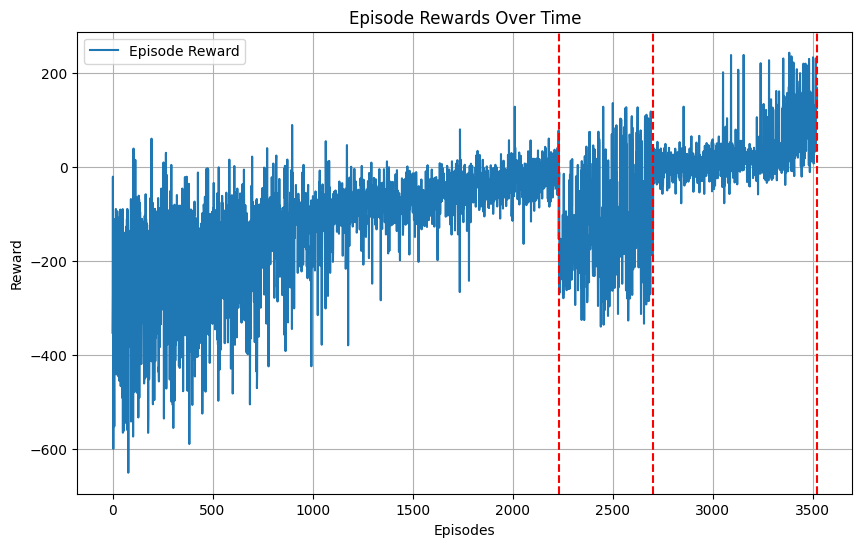

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label="Episode Reward")

for x in env_end_idx:
    plt.axvline(x=x, color="red", linestyle="--")

plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Episode Rewards Over Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# render the agent demo
vec_env = make_vec_env("LunarLander-v3", n_envs=1)
obs = vec_env.reset()

for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    vec_env.render("human")